# 神經網路實做

## 拿取加權指數資料

In [26]:
from finlab.data import Data

data = Data()
twii = data.get("發行量加權股價指數")

twii = twii['台股指數'].resample("15T").first().dropna()
twii.head()

date
2006-01-02 09:00:00    6548.34
2006-01-02 09:15:00    6478.09
2006-01-02 09:30:00    6474.88
2006-01-02 09:45:00    6471.12
2006-01-02 10:00:00    6480.50
Name: 台股指數, dtype: float64

## 製作features

In [27]:
import talib
import numpy as np
import pandas as pd

sma = talib.SMA(twii, timeperiod=120)
wma = talib.WMA(twii, timeperiod=120)
mom = talib.MOM(twii, timeperiod=120)
k, d = talib.STOCH  (twii, twii, twii, fastk_period=120, slowk_period=60, slowd_period=60)
k2, d2 = talib.STOCH(twii, twii, twii, fastk_period=240, slowk_period=120, slowd_period=120)
k3, d3 = talib.STOCH(twii, twii, twii, fastk_period=360, slowk_period=180, slowd_period=180)
k4, d4 = talib.STOCH(twii, twii, twii, fastk_period=480, slowk_period=240, slowd_period=240)
k5, d5 = talib.STOCH(twii, twii, twii, fastk_period=640, slowk_period=320, slowd_period=320)
k6, d6 = talib.STOCH(twii, twii, twii, fastk_period=720, slowk_period=360, slowd_period=360)
k7, d7 = talib.STOCH(twii, twii, twii, fastk_period=840, slowk_period=420, slowd_period=420)
k8, d8 = talib.STOCH(twii, twii, twii, fastk_period=960, slowk_period=480, slowd_period=480)

rsi = talib.RSI (twii, timeperiod=120)
rsi2 = talib.RSI(twii, timeperiod=240)
rsi3 = talib.RSI(twii, timeperiod=480)
rsi4 = talib.RSI(twii, timeperiod=640)
rsi5 = talib.RSI(twii, timeperiod=720)
rsi6 = talib.RSI(twii, timeperiod=840)

macd1, macd2, macd3 = talib.MACD(twii, fastperiod=120, slowperiod=60, signalperiod=60)
willr = talib.WILLR(twii, twii, twii, timeperiod=120)
cci = talib.CCI(twii, twii, twii, timeperiod=120)

dataset = pd.DataFrame({
    'RSIb': rsi / 50,
    'RSIb2': rsi2 / 50,
    'RSIb3': rsi3 / 50,
    'RSIb4': rsi4 / 50,
    'RSIb5': rsi5 / 50,
    'RSIb6': rsi6 / 50,
    'MOMb': mom - 0,
    'KDb': k - d,
    'KDb2': k2 - d2,
    'KDb3': k3 - d3,
    'KDb4': k4 - d4,
    'KDb5': k5 - d5,
    'KDb6': k6 - d6,
    'KDb7': k7 - d7,
    'KDb8': k8 - d8,
    
    'a5':   (twii.rolling(5).mean()   / twii),
    'a10':  (twii.rolling(10).mean()  / twii),
    'a20':  (twii.rolling(20).mean()  / twii),
    'a40':  (twii.rolling(40).mean()  / twii),
    'a80':  (twii.rolling(80).mean()  / twii),
    'a160': (twii.rolling(160).mean() / twii),
    'a320': (twii.rolling(320).mean() / twii),
    'a640': (twii.rolling(640).mean() / twii),
    'a720': (twii.rolling(720).mean() / twii),
    'a840': (twii.rolling(840).mean() / twii),
    'a960': (twii.rolling(960).mean() / twii),
    'a1024':(twii.rolling(1024).mean() / twii),
    'b1': twii/twii.shift(50),
    'b2': twii/twii.shift(100),
    'b3': twii/twii.shift(150),
    'b4': twii/twii.shift(200),
    'b5': twii/twii.shift(250),
    'b6': twii/twii.shift(300),
    'b7': twii/twii.shift(350),
    'LINEARREG_SLOPE0': talib.LINEARREG_SLOPE(twii, 60),
    'LINEARREG_SLOPE1': talib.LINEARREG_SLOPE(twii, 120),

    'ADXR0': talib.ADXR(twii, twii, twii, 60),
    'ADXR1': talib.ADXR(twii, twii, twii, 120),
    'ADXR2': talib.ADXR(twii, twii, twii, 240),
    'ADXR3': talib.ADXR(twii, twii, twii, 360),
    'ADXR4': talib.ADXR(twii, twii, twii, 480),
    'ADXR5': talib.ADXR(twii, twii, twii, 640),

    'return': twii.shift(-10) / twii,
})

feature_names = list(dataset.columns[:-1])

## 簡單處理一下

In [28]:
print("before dropping NaN", dataset.shape)
dataset = dataset.dropna()
print("after dropping NaN", dataset.shape)


before dropping NaN (78090, 43)
after dropping NaN (76162, 43)


In [29]:
import lightgbm as lgb
dataset_train = dataset[:'2015']

gbm = lgb.LGBMClassifier(n_estimators=100, random_state=5, learning_rate=0.01)

gbm.fit(dataset_train[feature_names], dataset_train['return'] > 1)


[LightGBM] [Info] Number of positive: 23308, number of negative: 21913
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003236 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10710
[LightGBM] [Info] Number of data points in the train set: 45221, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.515424 -> initscore=0.061717
[LightGBM] [Info] Start training from score 0.061717


LGBMClassifier(learning_rate=0.01, random_state=5)

## 神經網路Preprocessing

In [30]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()

dataset_scaled = ss.fit_transform(dataset)
dataset_scaled = pd.DataFrame(dataset_scaled, columns=dataset.columns, index=dataset.index)
dataset_scaled['return'] = dataset['return']
dataset_scaled.describe()

,RSIb,RSIb2,RSIb3,RSIb4,RSIb5,RSIb6,MOMb,KDb,KDb2,KDb3,...,b7,LINEARREG_SLOPE0,LINEARREG_SLOPE1,ADXR0,ADXR1,ADXR2,ADXR3,ADXR4,ADXR5,return
count,7.616200e+04,7.616200e+04,7.616200e+04,7.616200e+04,7.616200e+04,7.616200e+04,7.616200e+04,7.616200e+04,7.616200e+04,7.616200e+04,...,7.616200e+04,7.616200e+04,7.616200e+04,7.616200e+04,7.616200e+04,7.616200e+04,7.616200e+04,7.616200e+04,7.616200e+04,76162.000000
mean,7.612758e-16,-1.552406e-16,-8.000859e-16,-3.283935e-16,-6.143943e-15,-4.340765e-15,2.089777e-17,-2.313681e-17,-1.921848e-17,5.597616e-18,...,-1.662865e-15,-1.044888e-17,8.956186e-18,-1.836018e-16,-4.284042e-16,1.641967e-16,1.761383e-16,-2.597294e-16,-1.418063e-16,1.000140
std,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,...,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,0.008226
min,-4.420273e+00,-4.571655e+00,-4.844865e+00,-4.830318e+00,-4.798296e+00,-4.732656e+00,-9.043366e+00,-2.585279e+00,-2.681749e+00,-2.668871e+00,...,-5.526049e+00,-9.479454e+00,-7.220371e+00,-2.113092e+00,-2.013057e+00,-1.699734e+00,-1.607631e+00,-1.743051e+00,-1.788210e+00,0.924507
25%,-6.808589e-01,-6.805118e-01,-6.701653e-01,-6.643241e-01,-6.602131e-01,-6.502258e-01,-4.628830e-01,-6.431063e-01,-6.457566e-01,-6.308559e-01,...,-5.247780e-01,-4.650399e-01,-4.711497e-01,-7.429286e-01,-6.983777e-01,-7.491920e-01,-7.029094e-01,-6.840126e-01,-7.157764e-01,0.997014
50%,9.804691e-02,1.161562e-01,1.130169e-01,1.170881e-01,1.218558e-01,1.276173e-01,8.838265e-02,-1.193381e-02,-3.042855e-02,-8.651718e-03,...,1.182274e-01,7.799646e-02,8.037066e-02,-1.505860e-01,-2.295839e-01,-2.701732e-01,-2.505890e-01,-2.338925e-01,-2.145211e-01,1.000293
75%,7.227951e-01,7.118843e-01,6.842685e-01,6.901158e-01,6.887092e-01,6.868917e-01,5.728830e-01,6.585073e-01,6.711449e-01,6.056063e-01,...,5.773039e-01,5.656572e-01,5.730772e-01,5.933363e-01,4.659815e-01,4.982681e-01,4.896800e-01,4.939855e-01,5.710564e-01,1.003695
max,2.883627e+00,2.830158e+00,3.037121e+00,3.113137e+00,3.131951e+00,3.145406e+00,5.022297e+00,2.728150e+00,2.591319e+00,2.560138e+00,...,4.884701e+00,4.756142e+00,4.025058e+00,4.525993e+00,4.107300e+00,3.862548e+00,3.572192e+00,3.677621e+00,3.531789e+00,1.087726


In [31]:
#切割時間軸

import tqdm

n = 3

X = []
y = []
indexes = []
dataset_scaled_x = dataset_scaled[feature_names]

for i in tqdm.tqdm_notebook(range(0, len(dataset_scaled)-n)):
    X.append(dataset_scaled_x.iloc[i:i+n].values)
    y.append(dataset_scaled['return'].iloc[i+n-1])
    indexes.append(dataset_scaled.index[i+n-1])
#dataset_scaled.head()

C:\Users\jerry\AppData\Local\Temp\ipykernel_4248\1713141429.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm.tqdm_notebook(range(0, len(dataset_scaled)-n)):


  0%|          | 0/76159 [00:00<?, ?it/s]

In [32]:
import numpy as np
X = np.array(X)
y = np.array(y)

In [33]:
indexes = np.array(indexes)

## 神經網路 Model

In [34]:
from tensorflow import keras
from tensorflow.keras import layers

model = keras.models.Sequential()
#model.add(keras.layers.Dense(100, activation="relu", input_shape=(len(feature_names),)))
model.add(layers.LSTM(100, return_sequences=True, input_shape=X[0].shape))
model.add(layers.LSTM(100))
model.add(layers.Dense(8))
model.add(layers.Dense(1,kernel_initializer="uniform",activation='linear'))

adam = keras.optimizers.Adam(0.0006)

model.compile(optimizer=adam, loss="binary_crossentropy", metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 3, 100)            57200     
                                                                 
 lstm_3 (LSTM)               (None, 100)               80400     
                                                                 
 dense_2 (Dense)             (None, 8)                 808       
                                                                 
 dense_3 (Dense)             (None, 1)                 9         
                                                                 
Total params: 138,417
Trainable params: 138,417
Non-trainable params: 0
_________________________________________________________________


## 神經網路訓練

In [35]:
# dataset_scaled_train = dataset_scaled[:'2015']

import datetime
X_train = X[indexes < datetime.datetime(2023, 1, 1)]
y_train = y[indexes < datetime.datetime(2023, 1, 1)]

checkpoint_filepath = './lstm_model.h5'
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

history = model.fit(
    X_train,
    y_train > 1,
    batch_size=256,
    epochs=100,
    validation_split=0.2,
    callbacks=[model_checkpoint_callback])

Epoch 1/100
238/238 [==============================] - 4s 10ms/step - loss: 1.1461 - accuracy: 0.4926 - val_loss: 0.7224 - val_accuracy: 0.4913
Epoch 2/100
238/238 [==============================] - 1s 6ms/step - loss: 0.6988 - accuracy: 0.5227 - val_loss: 0.6997 - val_accuracy: 0.5075
Epoch 3/100
238/238 [==============================] - 1s 6ms/step - loss: 0.6905 - accuracy: 0.5334 - val_loss: 0.6956 - val_accuracy: 0.5136
Epoch 4/100
238/238 [==============================] - 1s 6ms/step - loss: 0.6872 - accuracy: 0.5462 - val_loss: 0.6942 - val_accuracy: 0.5190
Epoch 5/100
238/238 [==============================] - 1s 6ms/step - loss: 0.6843 - accuracy: 0.5534 - val_loss: 0.6953 - val_accuracy: 0.5200
Epoch 6/100
238/238 [==============================] - 1s 6ms/step - loss: 0.6815 - accuracy: 0.5607 - val_loss: 0.6947 - val_accuracy: 0.5209
Epoch 7/100
238/238 [==============================] - 1s 6ms/step - loss: 0.6786 - accuracy: 0.5674 - val_loss: 0.7053 - val_accuracy: 0.505

In [36]:
model.load_weights(checkpoint_filepath)

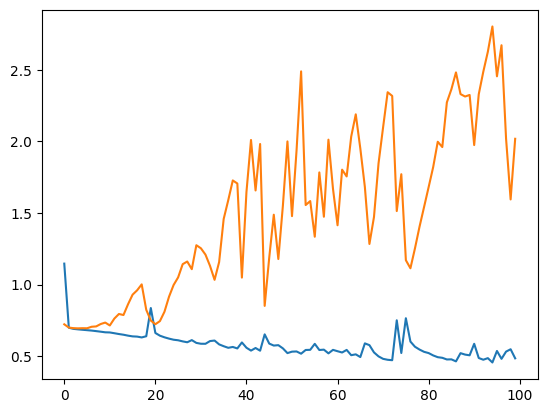

In [37]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

## 回測

2380/2380 [==============================] - 4s 2ms/step


<Axes: >

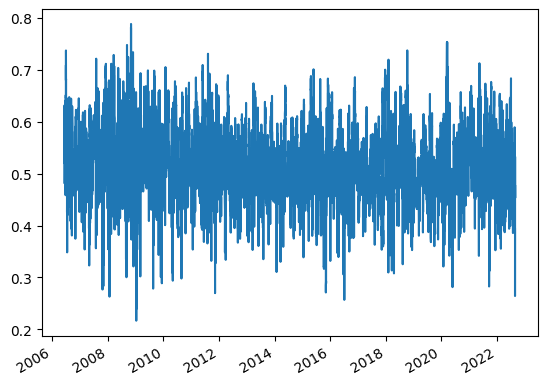

In [38]:
ey = model.predict(X)
ey = pd.Series(ey.swapaxes(0,1)[0], index=indexes)
ey.plot()


<Axes: xlabel='date'>

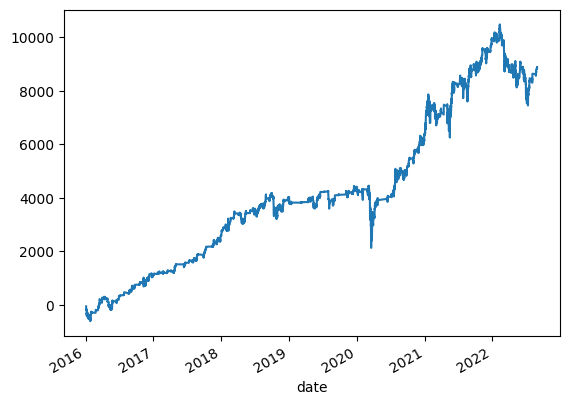

In [43]:
eq = twii[indexes]
returns = (eq.shift(-1) - eq)

signal = (ey > ey.quantile(0.6)).rolling(10).sum() > 0
signal = signal.shift(1).fillna(False)

eq = (returns[signal]['2016':]).cumsum()
eq.plot()

In [44]:
(signal.astype(int).diff().abs().fillna(0) * 3)['2016':].sum()

1317.0